In [1]:
import pandas as pd
import math
from functools import reduce
from sklearn import linear_model
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('chained_assignment',None)
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import r2_score

In [2]:
main_df = pd.read_excel('C:/Users/lzoeckler/Desktop/decay/DBS_stability_2.xlsx')
main_df.rename(columns={'Unnamed: 0': 'analyte', 'Unnamed: 1': 'treatment_condition',
                       'Unnamed: 2': 'time_or_humidity'}, inplace=True)
main_df.loc[main_df['analyte'] == 'Pv LDH', 'analyte'] = 'Pv_LDH'
main_df.loc[main_df['analyte'] == 'Pf LDH', 'analyte'] = 'Pf_LDH'
main_df.head()

,analyte,treatment_condition,time_or_humidity,Hi,Med,Low
0,HRP2,-20oC,1.0,1546.99,806.53,79.33
1,HRP2,-20oC,3.0,1300.62,791.51,64.99
2,HRP2,-20oC,7.0,1582.84,897.24,88.90
3,HRP2,-20oC,15.0,1547.39,691.08,67.17
4,HRP2,-20oC,30.0,1648.93,927.27,93.60


In [3]:
main_df['analyte'].unique()

array(['HRP2', 'Pv_LDH', 'Pf_LDH', 'CRP'], dtype=object)

In [4]:
def temp_adjust(df):
    temp = df['treatment_condition']
    temp = temp.replace("oC", "")
    temp = int(temp)
    return temp

In [5]:
time_df = main_df.loc[main_df['treatment_condition'] != 'Humidity']
time_df['treatment_condition'] = time_df.apply(temp_adjust, axis=1)
time_df['treatment_condition'].unique()

array([-20,   4,  23,  30,  50], dtype=int64)

In [6]:
time_df['time_or_humidity'].unique()

array([  1.,   3.,   7.,  15.,  30.,  60., 120., 240.])

In [7]:
base_value_df = time_df.loc[time_df['treatment_condition'] == -20]
base_value_df = base_value_df.groupby(['analyte', 'treatment_condition']).mean().reset_index()
base_value_df.drop(['treatment_condition', 'time_or_humidity'], axis=1, inplace=True)
base_value_df

,analyte,Hi,Med,Low
0,CRP,17950.92500,7628.23500,699.82500
1,HRP2,1534.43625,825.94375,83.70375
2,Pf_LDH,12022.15500,6948.41500,796.22750
3,Pv_LDH,4976.20875,2897.74000,312.14625


In [8]:
time_df = time_df.loc[time_df['treatment_condition'] != -20]
time_df = time_df.merge(base_value_df, on='analyte', suffixes=('', '_base'))
time_df.head()

,analyte,treatment_condition,time_or_humidity,Hi,Med,Low,Hi_base,Med_base,Low_base
0,HRP2,4,1.0,1937.11,1006.40,79.08,1534.43625,825.94375,83.70375
1,HRP2,4,3.0,1438.96,875.57,76.59,1534.43625,825.94375,83.70375
2,HRP2,4,7.0,1748.31,945.54,105.97,1534.43625,825.94375,83.70375
3,HRP2,4,15.0,1563.24,809.20,73.14,1534.43625,825.94375,83.70375
4,HRP2,4,30.0,1716.19,1039.20,222.44,1534.43625,825.94375,83.70375


In [9]:
end_df = time_df.loc[time_df['time_or_humidity'] == 240.0]
end_df.drop('time_or_humidity', axis=1, inplace=True)
end_df['decay'] = True
for concentration in ['Hi', 'Med', 'Low']:
    end_df.loc[end_df[concentration] > end_df['{}_base'.format(concentration)], 'decay'] = False
    end_df.drop([concentration, '{}_base'.format(concentration)], axis=1, inplace=True)
end_df.head()

,analyte,treatment_condition,decay
7,HRP2,4,False
15,HRP2,23,True
23,HRP2,30,True
31,HRP2,50,True
39,Pv_LDH,4,True


In [10]:
time_df = time_df.merge(end_df, on=['analyte', 'treatment_condition'])
time_df = time_df.loc[time_df['decay'] == True]
time_df.drop('decay', axis=1, inplace=True)
time_df[['Hi_base', 'Med_base', 'Low_base']] = time_df[['Hi_base', 'Med_base', 'Low_base']].divide(2)
time_df.head()

,analyte,treatment_condition,time_or_humidity,Hi,Med,Low,Hi_base,Med_base,Low_base
8,HRP2,23,1.0,1624.16,782.59,73.91,767.218125,412.971875,41.851875
9,HRP2,23,3.0,1719.94,1006.65,66.80,767.218125,412.971875,41.851875
10,HRP2,23,7.0,1933.20,1041.30,88.31,767.218125,412.971875,41.851875
11,HRP2,23,15.0,1775.97,823.60,72.80,767.218125,412.971875,41.851875
12,HRP2,23,30.0,1784.90,951.14,100.68,767.218125,412.971875,41.851875


In [11]:
log_df = time_df.copy(deep=True)
cols = ['Hi', 'Med', 'Low', 'Hi_base', 'Med_base', 'Low_base']
log_df[cols] = log_df[cols].applymap(math.log)
log_df.head()

,analyte,treatment_condition,time_or_humidity,Hi,Med,Low,Hi_base,Med_base,Low_base
8,HRP2,23,1.0,7.392746,6.662609,4.302848,6.642771,6.023379,3.734137
9,HRP2,23,3.0,7.450045,6.914383,4.201703,6.642771,6.023379,3.734137
10,HRP2,23,7.0,7.566932,6.948225,4.480853,6.642771,6.023379,3.734137
11,HRP2,23,15.0,7.482102,6.713685,4.287716,6.642771,6.023379,3.734137
12,HRP2,23,30.0,7.487118,6.857661,4.611947,6.642771,6.023379,3.734137


In [12]:
test_df = log_df.copy(deep=True)
main_dfs = []
for analyte in time_df['analyte'].unique():
    an_df = test_df.loc[test_df['analyte'] == analyte]
    analyte_dfs = []
    for concentration in ['Hi', 'Med', 'Low']:
        con_df = an_df[['analyte', 'treatment_condition', 'time_or_humidity',
                        concentration, '{}_base'.format(concentration)]]
        half_base = con_df['{}_base'.format(concentration)].tolist()[0]
        concentration_dfs = []
        for temp in con_df['treatment_condition'].unique():
            temp_df = con_df.loc[con_df['treatment_condition'] == temp]
            temp_df.drop('{}_base'.format(concentration), axis=1, inplace=True)
            regr = linear_model.LinearRegression()
            time = temp_df['time_or_humidity'].values.reshape(-1,1)
            con = temp_df[concentration].values.reshape(-1,1)
            regr.fit(time, con)
            pred = regr.predict(time)
            coef = np.float(regr.coef_)
            intercept = np.float(regr.intercept_)
            log_half_life = (half_base - intercept) / coef
            true_half = np.exp(log_half_life)
            temp_df['{}_half_life'.format(concentration)] = log_half_life
            concentration_dfs.append(temp_df)
        concentration_df = pd.concat(concentration_dfs)
        concentration_df.drop(concentration, axis=1, inplace=True)
        analyte_dfs.append(concentration_df)
    analyte_df = reduce(lambda left, right: pd.merge(left, right, on=['analyte', 'treatment_condition',
                                                                      'time_or_humidity']), analyte_dfs)
    main_dfs.append(analyte_df)
main_df = pd.concat(main_dfs)
main_df.drop('time_or_humidity', axis=1, inplace=True)
main_df.drop_duplicates(inplace=True)
main_df.head()

,analyte,treatment_condition,Hi_half_life,Med_half_life,Low_half_life
0,HRP2,23,690.184364,531.797912,18966.935448
8,HRP2,30,419.790836,374.556145,464.389681
16,HRP2,50,70.894925,81.796226,73.410652
0,Pv_LDH,4,777.218470,1007.505160,1817.891707
8,Pv_LDH,23,188.279021,154.025154,123.328660


In [13]:
main_df.to_csv('C:/Users/lzoeckler/Desktop/decay/log_half_life.csv', index=False)

C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


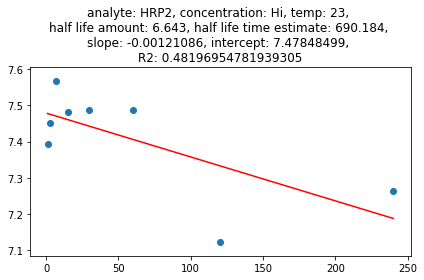

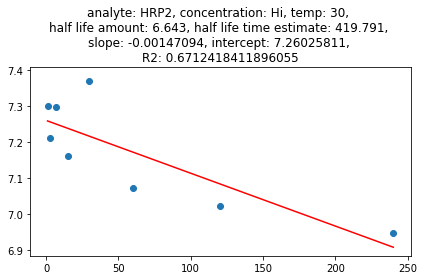

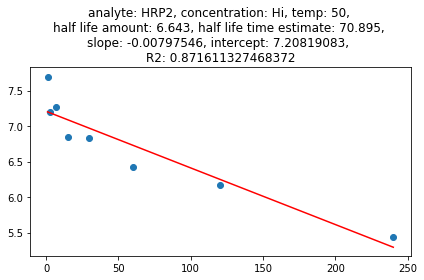

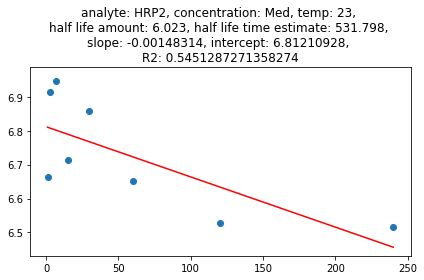

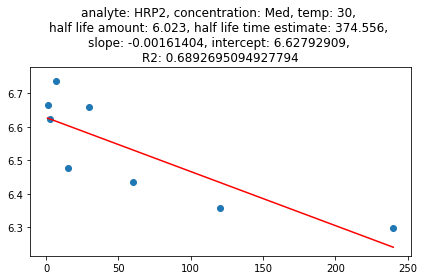

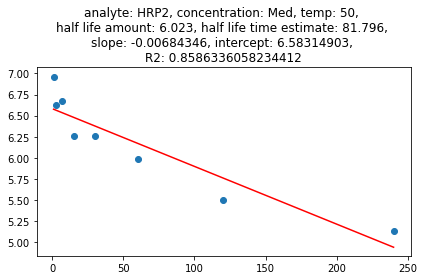

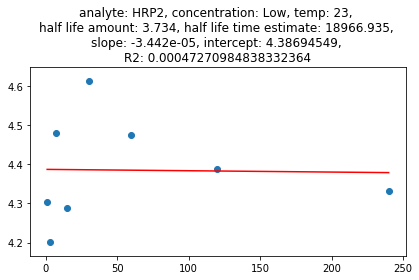

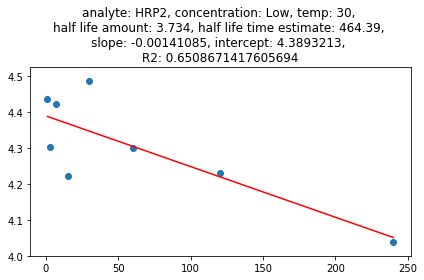

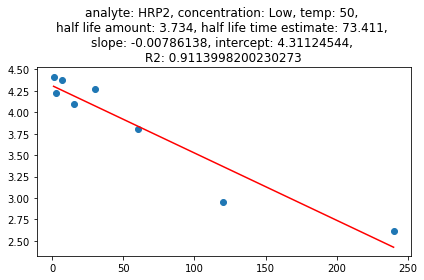

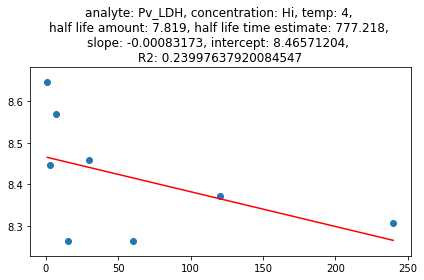

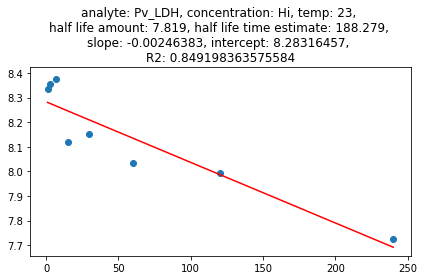

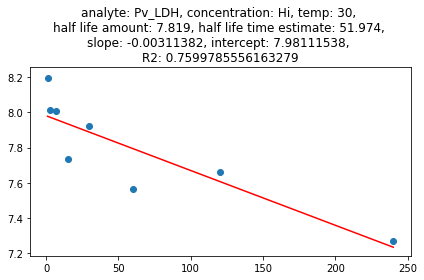

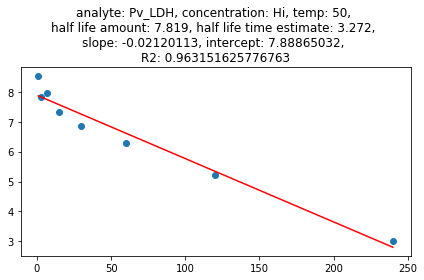

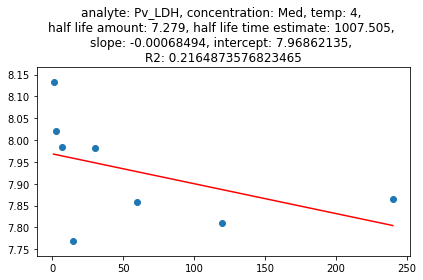

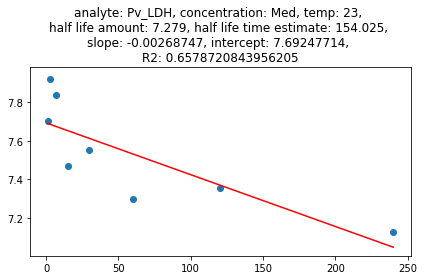

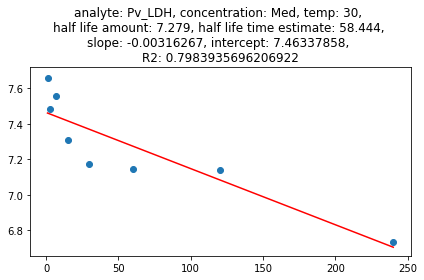

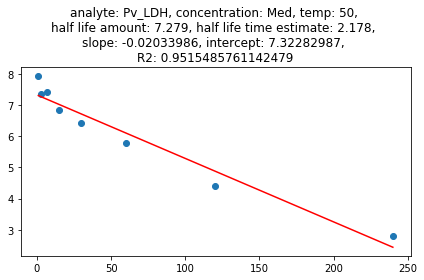

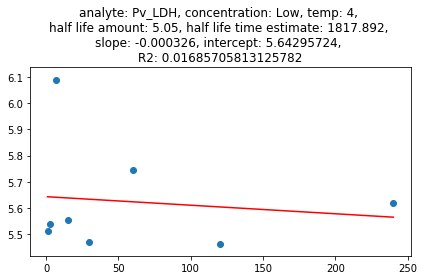

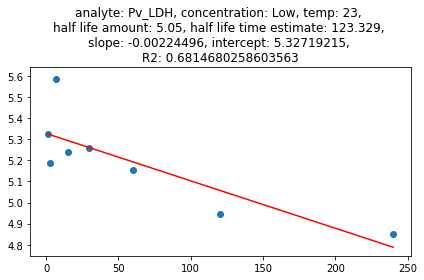

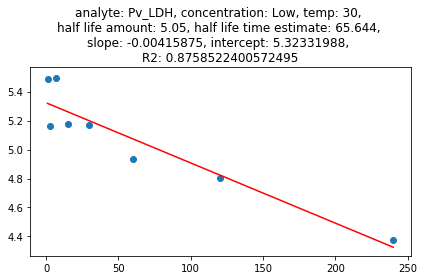

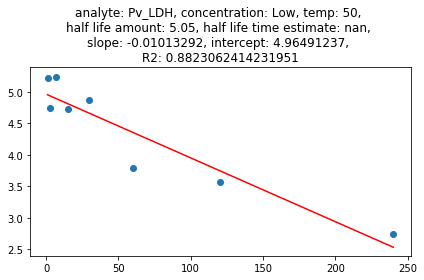

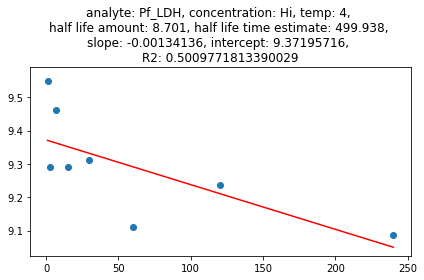

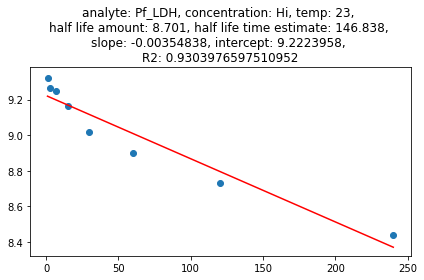

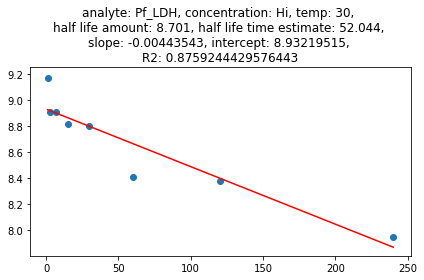

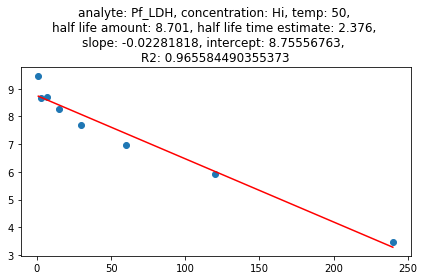

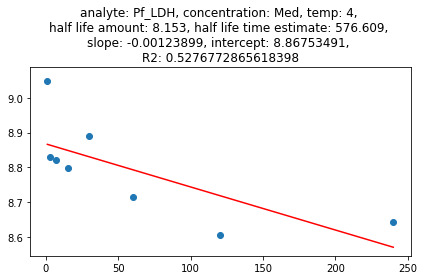

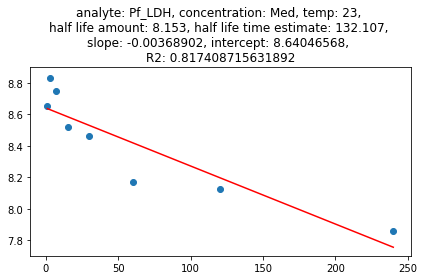

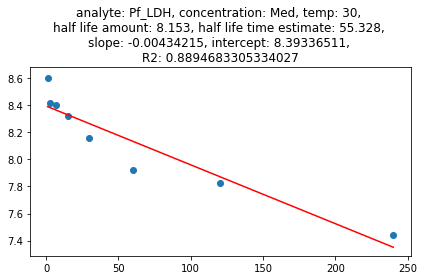

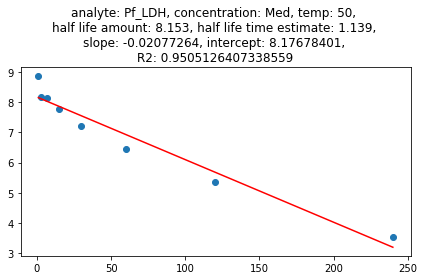

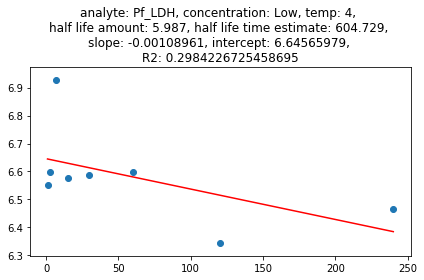

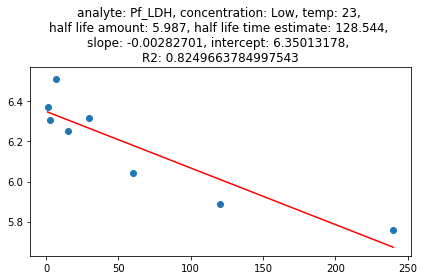

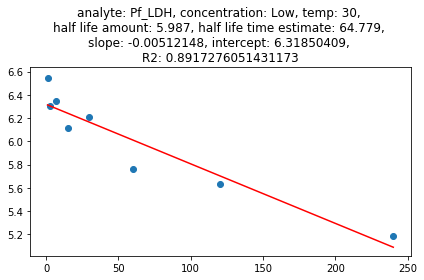

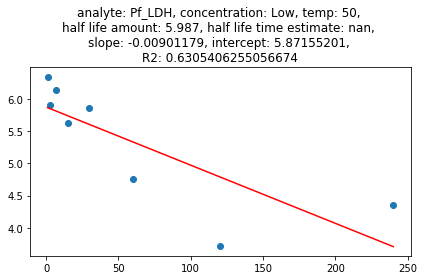

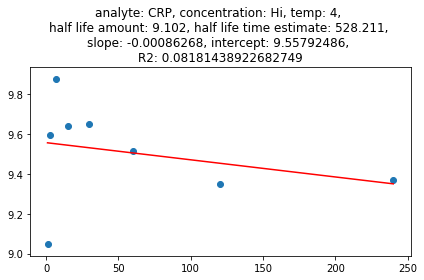

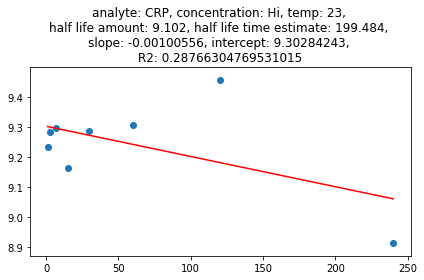

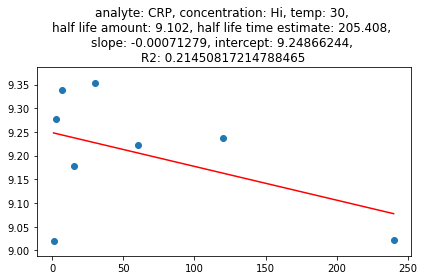

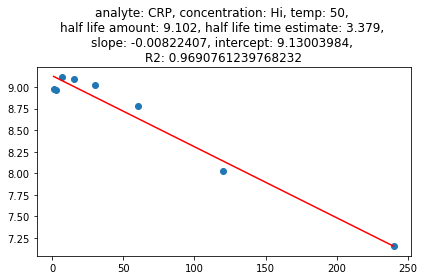

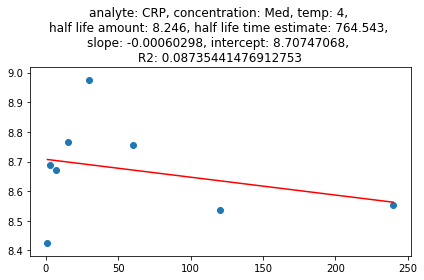

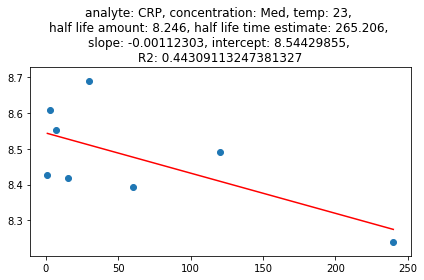

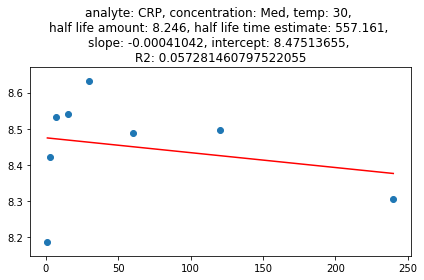

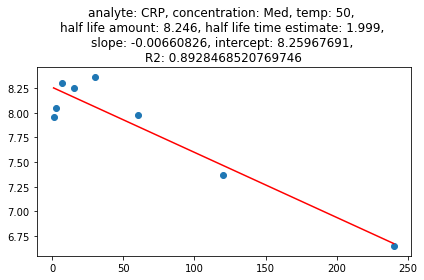

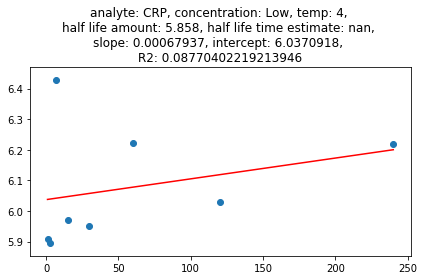

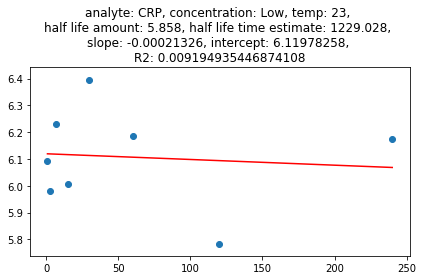

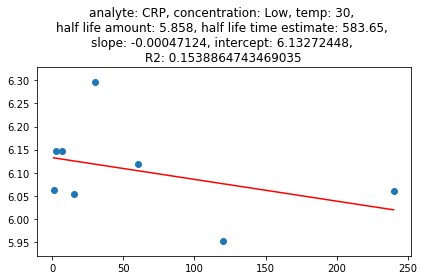

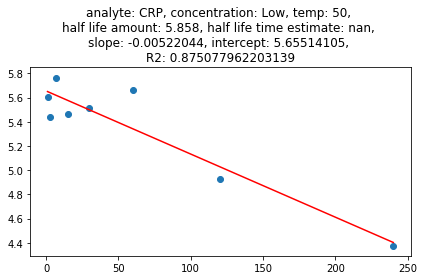

In [15]:
test_df = log_df.copy(deep=True)
# test_df = test_df.loc[test_df['time_or_humidity'] > 15]
pp = PdfPages('C:/Users/lzoeckler/Desktop/decay/log_regression_log_space.pdf')
for analyte in time_df['analyte'].unique():
    an_df = test_df.loc[test_df['analyte'] == analyte]
    for concentration in ['Hi', 'Med', 'Low']:
        con_df = an_df[['treatment_condition', 'time_or_humidity',
                        concentration, '{}_base'.format(concentration)]]
        half_base = con_df['{}_base'.format(concentration)].tolist()[0]
        for temp in con_df['treatment_condition'].unique():
            temp_df = con_df.loc[con_df['treatment_condition'] == temp]
            temp_df.drop(['treatment_condition', '{}_base'.format(concentration)], axis=1, inplace=True)
            regr = linear_model.LinearRegression()
            time = temp_df['time_or_humidity'].values.reshape(-1,1)
            con = temp_df[concentration].values.reshape(-1,1)
            regr.fit(time, con)
            pred = regr.predict(time)
            score = r2_score(con, pred)
            coef = np.float(regr.coef_)
            intercept = np.float(regr.intercept_)
            log_half_life = (half_base - intercept) / coef
            if log_half_life < 0:
                log_half_life = np.nan
            else:
                log_half_life = round(log_half_life, 3)
            trans_con = np.exp(con)
            trans_pred = np.exp(pred)
            f = plt.figure()
            plt.scatter(time, con)
            plt.plot(time, pred, color='red')
            true_half_base = np.exp(half_base)
            title = """analyte: {}, concentration: {}, temp: {}, \nhalf life amount: {}, half life time estimate: {}, \nslope: {}, intercept: {}, \nR2: {}""".format(
                analyte, concentration, temp, round(half_base, 3), log_half_life, round(coef, 8),
                round(intercept, 8), score)
            plt.title(title)
            plt.tight_layout()
            pp.savefig(f)
pp.close()